# Practical Deep Learning Part 1: Review Notes
An answer to the review notes questions

#### _Were computers smart enough to determine photos of birds before 2015?_
No, they were not. They struggled with this classifcation task

#### _How to download and display a photo from DuckDuckGO?_

In [1]:
%pip install fastbook
%pip install duckduckgo-search

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 20.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 22.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from fastcore.all import *
from fastbook import *

def search_images(image_name, max_images=25):
    return search_images_ddg(image_name, max_images)

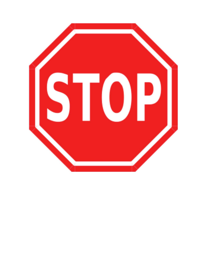

In [3]:
from fastdownload import download_url

urls = search_images_ddg('stop sign photo', 1)
dest = 'test.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
test_image = Image.open(dest)
test_image.to_thumb(256, 256)

#### _How to create multiple folders and a path for images to be downloaded into_

In [4]:
searches = 'stop sign', 'construction sign', 'yield sign', 'person crossing road'
path = Path('road_stuff')
from time import sleep

def changed_environment(dest, im):
    download_images(dest, urls=search_images(f'{im} photo'))
    download_images(dest, urls=search_images(f'{im} night photo'))
    download_images(dest, urls=search_images(f'{im} rain photo'))

for x in searches:
    dest = (path/x)
    dest.mkdir(exist_ok=True, parents=True)
    changed_environment(dest, x)
    resize_images(path/x, max_size=400, dest=path/x)

#### _Removing broken images from folders_

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

#### _Creating a DataBlock_
To train any model, you need **dataloaders** which are objects containing a training set and a validation set. A **DataBlock** is FastAI's approach to dataloaders made easy.

In [6]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

**Breakdown of each parameter in a DataBlock** ^

* blocks = (ImageBlock, CategoryBlock)
    * Our model's input are images and output is categories (labels). This is enough for fastai to know what kind of model to build for us 
* get_items = get_image_files
    * To find all the inputs, get_image_files function (from the fastai library) will return a list of all images in our path
* splitter = RandomSplitter(valid_pct=0.2, seed=42)
    * Randomly splits our data so that 20% is the validation set. 
    * 42 for the seed is chosen arbritarily (can be any number) but as long as you keep it the same every time you run the code you'll have the same validation set
* get_y = parent_label
    * The labels (y-values) are the name of the parent folder of each path
* item_tfms=[Resize(192, method='squish')]
    * Transforms all images to the same side by squishing them
    * Comptuer vision models need all images to be the same size 

#### _Display random batch from DataBlock_

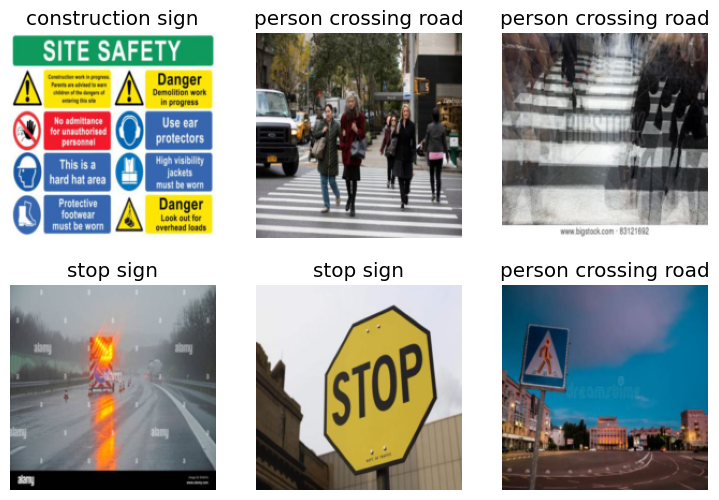

In [7]:
dls.show_batch(max_n=6)

#### _Build and train/finetune a model on your local computer_

In [8]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.672762,0.765325,0.783784,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.600575,0.602841,0.810811,00:05
1,0.447995,0.512578,0.846847,00:04
2,0.317702,0.470124,0.855856,00:04


**Model Training Breakdown**
* fastai uses the fine_tune() function to automatically refine a pre-trained model
* For discovering new models to use, go to [timm.fast.ai](https://timm.fast.ai/) which is a DL library automatically imported by fastai which comes with all the SOTA CV models. The website has docs breaking down the specifics for each
* Typically, resnet models are the way to go
    * Pre-trained on 1 million images of 1000 types (this dataset is known as the ImageNet dataset)
* On fastai, when you request a model, it downloads the optimized weights & biases based on ImageNet
    * Basically, always gives you the SOTA model

*fastai will always show you your model's accuracy using only the validation set - not training*

#### _Make your model predict or classify an image_
The three variables generated from the line below are all giving information about the prediction in different forms
* label --> what the model thinks the image is (_string_)
* _ --> 1/0 on if it is something (_int_)
* probs --> probability (_float_) 

In [9]:
label, _, probs = learn.predict(PILImage.create('0a993f76-8c16-4045-92e6-eaf4e60930c9.jpg'))
print(f"This is a: {label}.")
print(f"Probability it's a {label}: {probs[0]:.4f}")

This is a: person crossing road.
Probability it's a person crossing road: 0.0001


# Notes from Chapter 1

**Deep Learning Jargon**
* The functional form of the _model_ is called its _architecture_
* The *weights* are called *parameters*
* The *predictions* are calculated from the *independent variable*, which is the *data* not including the *labels*
* The *results* of the model are called *predictions*
* The measure of *performance* is called the *loss*
* The loss depends not only on the predictions, but also the correct *labels* (known as *targets* or *dependent variable*)

**Loss vs. Metric**
* The purpose of loss is to define a "measure of performance" that the training system can use to update weights automatically
    * Loss is what SGD uses
* A metric is defined for human consumption - something that makes it easy for us to interpret the model's performance

A loss function could be a suitable metric if one wishes

**Pretrained Models**

* When using <mark style="background-color: grey; color: white;">vision_learner</mark> it automatically sets the parameter <mark style="background-color: grey; color: white;">pretrained</mark> to <mark style="background-color: grey; color: white;">True</mark>
    * This gives the model weights based on the ImageNet dataset but removes the weights on the last layer, which is always specifcally customized for the training task at hand, and replaces it with one or more new layers with randomized weights

*Transfer learning* is when you use a pretrained model for a task different to what it was originally trained for

**Fine-tuning**

A transfer learning technique where the parameters of a pretrained model are updated by training for additional epochs using a different task to that used for pretraining.

Using <mark style="background-color: grey; color: white;">fine_tune</mark>, activates a two step step process to set parameters:

1. Use one epoch to fit just the head parameters
2. Use the defined number of epochs to fine-tune the rest of the model parameters

The *head* of the model is the part that is newly added to be specific to the new dataset.

Calling <mark style="background-color: grey; color: white;">fit</mark> will print the results of each epoch (epoch number, training and validation set losses, and metrics)

**Confused about fastai method?**

Use doc(learn.predict) --> or pass in whatever method name is relevant

**Training fastai models from scratch**

Use <mark style="background-color: grey; color: white;">fit_one_cycle(1)</mark> --> pass in number of epochs

**Hyperparameters**

*Hyperparameters* are changes that can be made in network architecture, learning rates, data augmentation strategies, and other factors to improve the model

It's important to note that a model can overfit on validation data it's tested on repeatedly while you are trying to adjust *hyperparameters*

The solution to this si by introducing a highly reserved set of data - the *test set*. This set will not be used to improve the model whatsoever, only to test it.

**Hiearchy of Data**
1. Test data - totally hidden
2. Validation data - less exposed
3. Training data - fully exposed

# Questionnaire

1. Do you need these for deep learning?

    Lots of math T / <mark>F</mark>

    Lots of data T / <mark>F</mark>

    Lots of expensive computers T / <mark>F</mark>

    A PhD T / <mark>F</mark>

2. Name five areas where deep learning is now the best in the world.

* NLP
* Medicine
* Computer vision
* Image generation
* Recommendation systems

3. What was the name of the first device that was based on the principle of the artificial neuron?

* Mark I Perceptrron by Frank Rosenblatt

4. Based on the book of the same name, what are the requirements for parallel distributed processing (PDP)?

* A set of *processing* units
* A *state of activation*
* An *output function* for each unit
* A *pattern of connectivity* among units
* A *propagation rule* for propagating patterns of activities through the network of connectivities
* A *learning rule* whereby patterns of connectivity are modified by experience
* An environment within which the system must operate

5. What were the two theoretical misunderstandings that held back the field of neural networks?

* Multi-layered neural networks were only a hypothesis by Minsky and Seymour who only experimented with single-layered systems
* In the '80s, networks with two-layers were extensively used and multi-layered networks were found to be too big and slow

6. What is a GPU?

* Graphics Processing Unit which is used to train machine learning models due to their ability to do thousands of tasks at the same time

7. Open a notebook and execute a cell containing: 1+1. What happens?

* The output is 2

8. Follow through each cell of the stripped version of the notebook for this chapter. Before executing each cell, guess what will happen.

* Done

9. Complete the Jupyter Notebook online appendix.

10. Why is it hard to use a traditional computer program to recognize images in a photo?

* Computers are not that smart - they need direct instructions on what to do. We're not sure what the direct instructions are for our brain to see an image, process it, and recognize it. Therefore, it's hard for us to tell a computer how to perform this task.

11. What did Samuel mean by "weight assignment"?

* Weight assignment refers to the current values of the model parameters 
* He further mentions an "*automatics means of testing the effectiveness of any current weight assignment*" and a "*mechanism for altering the weight assignment so as to maximize the performance*" 
    * This refers to the evaluation and training of the model in order to obtain a set of parameter values maximizes the model performance

12. What term do we normally use in deep learning for what Samuel called "weights"?

* Parameters

13. Draw a picture that summarizes Samuel's view of a machine learning model.

* Input + weights --> model --> results --> performance, where the performance --> (updates) weights, and repeat

14. Why is it hard to understand why a deep learning model makes a particular prediction?

* This is know as the interpretability of deep learning models
* This is difficult as a neural network gets more complex and has hundreds or thousands of layers feeding into and interacting with one another
* Recent research is making it easier to better understand a neural networks predictions, such as in CNNs

15. What is the name of the theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?

* Universal approximation theorem states that neural networks can theoretically represent any mathematical function.
* In practicality, due to available data and computer hardware, this is near impossible to do so - we get very close!

16. What do you need in order to train a model?

* The architecture for the given problem
    * Data (input)
    * Labels for your data to compare your model predictions to
    * Loss function to quantitatively measure the performance of your model
    * A way to update the parameters based on the loss (optimizer)

17. How could a feedback loop impact the rollout of a predictive policing model?

* The model is based on arrest data - not necessarily crime data so it pushes higher police presence in areas that already have high arrests
* This creates more arrests and more arrest data in those areas than anywhere else in the city for the model to learn from
* As a result, the model pushes for more and more police presence in that area leading to more and more arrests and more reinforcement for the model to continue doing that

18. Do we always have to use 224×224-pixel images with the cat recognition model?

* We don't - old neural networks specifically required that size of images but that's not the case anymore as long as all your images in your datasets are the same size
* The larger the image, the larger the compute needed

19. What is the difference between classification and regression?

* Classification predicts what an object is (is an image a dog or a cat)
* Regression predicts a numerical value (what temperature it is based on City name) 

20. What is a validation set? What is a test set? Why do we need them?

* A validation set is a small subset of the training set which will be used to test the accuracy of the model after it has passed through an epoch of training data
    * This is important to ensure you model is not overfitting and simply memorizing the labels of the training data
* A test set is a small set of highly reserved data which mimics real-world data, it's used to test the accuracy of your model after it has fully trained
    * This is very important to ensure that your network has not overfit on validation data and begun to memorize it instead of learning features

21. What will fastai do if you don't provide a validation set?

* Automatically create one that is 20% of your training set

22. Can we always use a random sample for a validation set? Why or why not?

* No, it doesn't always make sense. Eg; for time-series data you want the validation set to be the most recent data since the goal of the model is for it to be able to make predictions about the future, not the past.

23. What is overfitting? Provide an example.

* Training the model for too many epochs that it begins to memorize the training set instead of learning the features of the data

24. What is a metric? How does it differ from "loss"?

* A metric can be accuracy or error rate, which is a more human-friendly or intuitive way to measure the performance of a model than loss

25. How can pretrained models help?

* Already have very good initial weights and biases that well transfer over well for most tasks

26. What is the "head" of a model?

* Typically the last few layers, which are the ones that differentiates the most from model to model since that's what retains features specific to your problem

27. What kinds of features do the early layers of a CNN find? How about the later layers?

* Very broad horizontal, diagonal, and vertical edges - maybe color gradients as well.
* Later layers find more data specific features like the cirlces on the wheel of a car or the eyes of a human face

28. Are image models only useful for photos?

* No - any data that can be converted into image form and creates patterns/is recognizable by a human can be passed to an image model and perform pretty well 

29. What is an "architecture"?

* The architecture is the template or structure of the model we are trying to fit. It defines the mathematical model we are trying to fit

30. What is segmentation?

* Classifying each pixel of an image as something

31. What is y_range used for? When do we need it?

* For regression models to specify the range of their predictions - eg; if we want to predict the rating someone will give a movie we want to keep it from 0.5-5 stars

32. What are "hyperparameters"?

* High-level parameters that define *how* the model is traing 
    * Learning rate, network architecture, data augmentation, etc.

33. What's the best way to avoid failures when using AI in an organization?

* Have a good test set that can be used to confirm the usefulness of your model so that you can run that through the model that's been produced by "experts". 
* Try having a simple baseline, which ideally future models beat but even a simple baseline can be enough in some cases

# Further Research

1. Why is a GPU useful for deep learning? How is a CPU different, and why is it less effective for deep learning?

2. Try to think of three areas where feedback loops might impact the use of machine learning. See if you can find documented examples of that happening in practice